In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import string
import re
import math
from sklearn.feature_extraction import DictVectorizer
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import TruncatedSVD, PCA
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer
from sklearn.cluster import KMeans, DBSCAN
from sklearn import metrics
from hdbscan import HDBSCAN, validity_index
from urllib.parse import urlparse
from collections import Counter

In [2]:
np.random.seed(42)

# Clustering

This part of the project uses the cleaned dataset extracted in the previous notebook. With data cleaning out of the way, the next step for our analysis is clustering. In this section, we explore different clustering methods and parameters and do a evaluate the quality of results. Clustering will be done based on the number of time a speaker has been quoted by a publisher.

In [3]:
df = pd.read_csv("../data/clean_quotes.csv.bz2", usecols=["qids", "journal"])

In [4]:
df.head()

,qids,journal
0,Q20684375,people.com
1,Q20684375,people.com
2,Q20684375,people.com
3,Q20684375,people.com
4,Q20684375,people.com


We first count the number of occurences of a speaker for each publisher. Publishers with less than 10 quotes are removed: having very few quotes means there is not much information we can use to cluster them. This threshold is mostly arbitrary.

In [5]:
speakers_by_media = df.groupby("journal")
speakers_by_media_count = speakers_by_media.agg({"qids": Counter})

print(f"Media entities: {len(speakers_by_media)}")

Media entities: 5734


We then create vectors from these counts

In [6]:
vectorizer = DictVectorizer()
X = vectorizer.fit_transform(speakers_by_media_count["qids"])

print(f"Vector size: {X.shape[1]}")

Vector size: 40753


In [7]:
# Some useful method we will use from this point
# There is no need to understand them fully to grasp the reasoning below

def kmeans(X, k):
    return KMeans(
            n_clusters=k,
            init="k-means++",
            max_iter=100,
            n_init=1,
    ).fit_predict(X)

def dbscan(X, eps, min_samples):
    return HDBSCAN(min_cluster_size=min_samples, cluster_selection_epsilon=float(eps)).fit_predict(X)

def s_score(X, labels):
    X_no_noise = X[labels != -1]
    labels_no_noise = labels[labels != -1]
    if len(set(labels_no_noise)) < 2:
        return 0
    return metrics.silhouette_score(X_no_noise, labels_no_noise, random_state=42, sample_size=1000)

def dbcv_score(X, labels):
    X_no_noise = X[labels != -1]
    labels_no_noise = labels[labels != -1]
    if len(set(labels_no_noise)) < 2:
        return 0
    return validity_index(X_no_noise, labels_no_noise)

def plot_clusters(X, labels_list, titles, rows, cols):
    assert len(labels_list) == len(titles)
    assert len(labels_list) <= rows * cols
    
    fig, axs = plt.subplots(rows, cols, figsize=(20, 6), sharey=True, sharex=True)
    for i, (labels, title) in enumerate(zip(labels_list, titles)):
        ax = axs[i // cols, i % cols]
        ax.scatter(X[:,0], X[:,1], c=labels, alpha=0.6)
        ax.set_title(title)

def clusters_top_elements(labels, values_and_weights, n_samples = 10):
    for label in sorted(set(labels[labels >= 0])):
        members = values_and_weights[labels == label]
        sample_size = min(len(members), n_samples)
        print(f"\nCluster {label} ({len(members)} elements)")
        print(members.nlargest(sample_size, columns=["qids"]))

def dbscan_cluster_count(labels):
    return len(set(labels)) - (1 if -1 in labels else 0)
    

def dbscan_cluster_size_plot(X, labels, media_names):
    n_clusters = dbscan_cluster_count(labels)
    n_noise = list(labels).count(-1)

    print(f"{n_clusters} clusters")
    print(f"Some noise: {n_noise / len(labels) * 100:0.1f}%" if n_noise else "No noise")
    print(f"DBCV score: {dbcv_score(X, labels):0.2f}")
    clusters_top_elements(labels, media_names)
        
    pd.Series(Counter(labels)).plot.bar(title="Cluster sizes", xlabel="Cluster index", ylabel="Publisher count")
    
def dbscan_grid_plot(eps_values, ms_values, metrics, metric_index, title):
    fig, ax = plt.subplots(figsize=(10, 10))
    im = ax.imshow([[metrics[eps, ms][metric_index] for ms in ms_values] for eps in eps_values])

    # Show all ticks and label them with the respective list entries
    ax.set_xticks(np.arange(len(ms_values)), labels=ms_values)
    ax.set_yticks(np.arange(len(eps_values)), labels=eps_values)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    for i, eps in enumerate(eps_values):
        for j, ms in enumerate(ms_values):
            text = ax.text(j, i, f"{metrics[eps, ms][metric_index]:0.2f}", ha="center", va="center", color="w")

    ax.set_title(title)
    plt.show()

def make_lsa(dims):
    svd = TruncatedSVD(int(dims), random_state=42)
    normalizer = Normalizer(copy=False)
    return (svd, make_pipeline(svd, normalizer))

def fit_and_get_var(X, svd, lsa):
    lsa.fit(X)
    return svd.explained_variance_ratio_.sum()

Since the data is very high dimensional, we first apply dimensionality reduction. We use `TruncatedSVD`, which works with sparse data. Afterwards, we normalize the data. This combination is known as [latent semantic analysis](https://en.wikipedia.org/wiki/Latent_semantic_analysis), which is very useful to analyse relationships. We also produce a 2d version of the vectors using PCA for visualization purposes.

In [8]:
dims_values = [2, 3, 5, 10, 20, 30, 40, 50, 100, 200]
lsas = [make_lsa(dims) for dims in dims_values]
svds_explained_variance = [fit_and_get_var(X, svd, lsa) for svd, lsa in lsas]

First dimension with 95%+ explained variance: 30 (variance 0.9504)


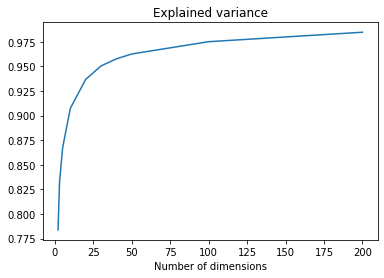

In [9]:
pd.Series(index=dims_values, data=svds_explained_variance).plot(title="Explained variance", xlabel="Number of dimensions")

dim_95, explained_var_95 = next((dims_values[i], var) for i, var in enumerate(svds_explained_variance) if var >= 0.95)
print(f"First dimension with 95%+ explained variance: {dim_95} (variance {explained_var_95:0.4f})")

In [10]:
svd = TruncatedSVD(dim_95, random_state=42)
normalizer = Normalizer(copy=False)
lsa = make_pipeline(svd, normalizer)

X_intermediate = lsa.fit_transform(X)
X_3d = PCA(n_components=3).fit_transform(X_intermediate)
X_2d = PCA(n_components=2).fit_transform(X_intermediate)

## KMeans

We first try clustering using KMeans with a range of values for k. We observe the best silouhette score with k=3

In [11]:
k_list = range(2, 10)

kmeans_labels = [kmeans(X_intermediate, k) for k in k_list]
kmeans_titles = [f"k = {k}" for k in k_list]

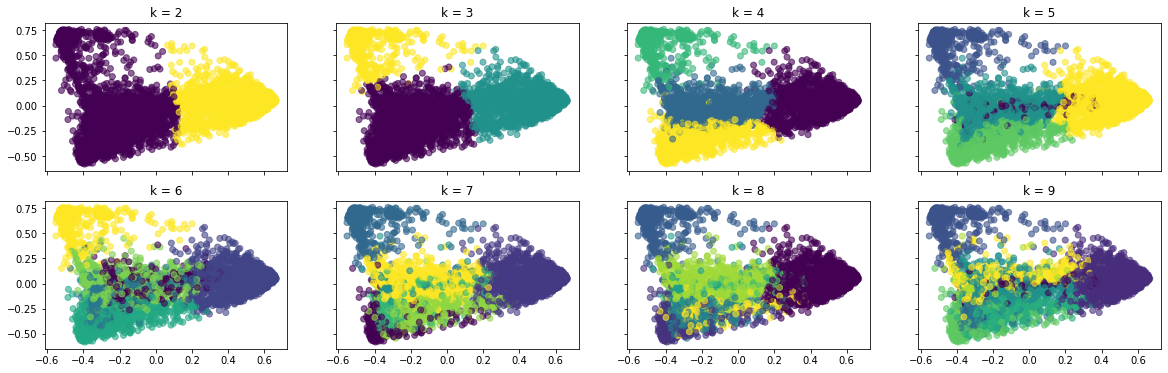

In [12]:
plot_clusters(X_2d, kmeans_labels, kmeans_titles, 2, 4)

<AxesSubplot:title={'center':'Silhouette score'}, xlabel='k'>

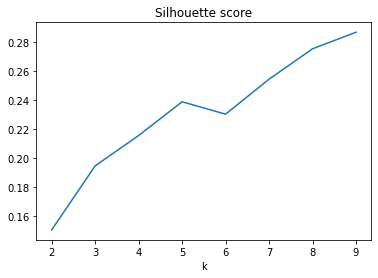

In [13]:
pd.Series(index=k_list, data=[s_score(X_intermediate, labels) for labels in kmeans_labels]).plot(title="Silhouette score", xlabel="k")

Showing biggest publishers for each cluster when k=3 shows some interesting results: publishers appear to be grouped geographically. The distribution of publishers between clusters is more or less balanced.


Cluster 0 (1850 elements)
                       qids
journal                    
einnews.com          140429
msn.com              105439
news965.com           56492
breitbart.com         53553
wokv.com              46676
washingtontimes.com   38527
foxnews.com           36557
wsbradio.com          34051
krmg.com              31864
nytimes.com           31798

Cluster 1 (457 elements)
                         qids
journal                      
people.com              13967
cheatsheet.com          12875
etonline.com            10057
femalefirst.co.uk        7259
billboard.com            6496
etcanada.com             6109
thehollywoodgossip.com   5905
eonline.com              5871
usmagazine.com           5855
hellomagazine.com        5438

Cluster 2 (647 elements)
                           qids
journal                        
express.co.uk             20147
mirror.co.uk              18427
bucksfreepress.co.uk      14511
eveningtimes.co.uk        13753
expressandstar.com        13533
w

<AxesSubplot:title={'center':'Cluster sizes'}, xlabel='Cluster index', ylabel='Publisher count'>

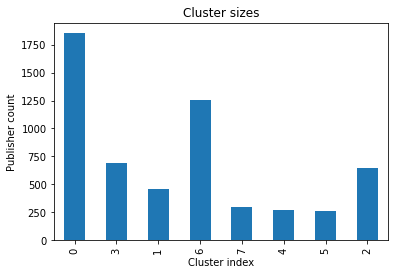

In [14]:
media_count = df.groupby("journal").count()
clusters_top_elements(kmeans_labels[6], media_count)
pd.Series(Counter(kmeans_labels[6])).plot.bar(title="Cluster sizes", xlabel="Cluster index", ylabel="Publisher count")

Although interesting, this clustering method might not be granular enough to really show more niche clusters.

## DBScan

We now try to use DBScan, adjusting `eps` parameter to get a sense of how it affects the results.

In [15]:
eps_values = [round(eps, 3) for eps in np.linspace(0.1, 0.4, 7)]
min_samples_values = np.linspace(10, 40, 11)
parameters = [(eps, min_samples) for eps in eps_values for min_samples in min_samples_values]

In [16]:
print("Clustering...")
dbscan_labels = [dbscan(X_intermediate, eps, int(ms)) for eps, ms in parameters]
print("Computing DBCV scores...")
dbscan_metrics = {(eps, ms): (dbcv_score(X_intermediate, labels), dbscan_cluster_count(labels)) for (eps, ms), labels in zip(parameters, dbscan_labels)}
print("Done")

Clustering...
0.1 10
0.1 13
0.1 16
0.1 19
0.1 22
0.1 25
0.1 28
0.1 31
0.1 34
0.1 37
0.1 40
0.15 10
0.15 13
0.15 16
0.15 19
0.15 22
0.15 25
0.15 28
0.15 31
0.15 34
0.15 37
0.15 40
0.2 10
0.2 13
0.2 16
0.2 19
0.2 22
0.2 25
0.2 28
0.2 31
0.2 34
0.2 37
0.2 40
0.25 10
0.25 13
0.25 16
0.25 19
0.25 22
0.25 25
0.25 28
0.25 31
0.25 34
0.25 37
0.25 40
0.3 10
0.3 13
0.3 16
0.3 19
0.3 22
0.3 25
0.3 28
0.3 31
0.3 34
0.3 37
0.3 40
0.35 10
0.35 13
0.35 16
0.35 19
0.35 22
0.35 25
0.35 28
0.35 31
0.35 34
0.35 37
0.35 40
0.4 10
0.4 13
0.4 16
0.4 19
0.4 22
0.4 25
0.4 28
0.4 31
0.4 34
0.4 37
0.4 40
Computing DBCV scores...
Done


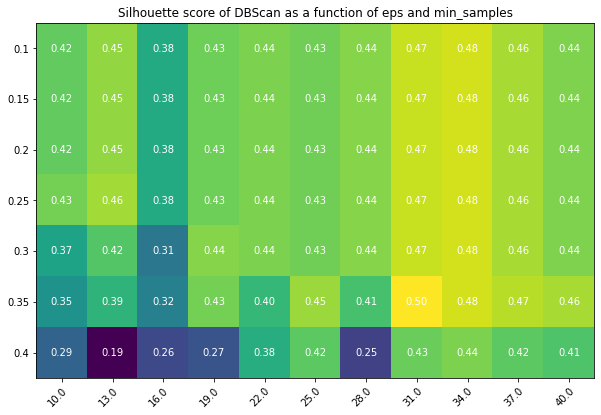

Best eps: 0.35, best min_samples: 31.0
Number of clusters: 15


In [17]:
dbscan_grid_plot(eps_values, min_samples_values, dbscan_metrics, 0, "Silhouette score of DBScan as a function of eps and min_samples")
best_eps, best_ms = max(dbscan_metrics, key=dbscan_metrics.get)
print(f"Best eps: {best_eps}, best min_samples: {best_ms}")
print(f"Number of clusters: {dbscan_metrics[best_eps, best_ms][1]}")

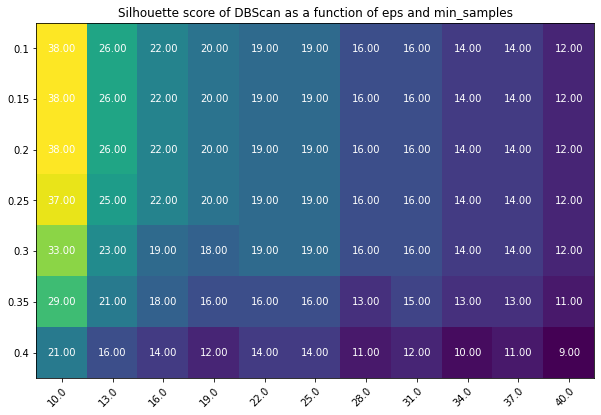

In [18]:
dbscan_grid_plot(eps_values, min_samples_values, dbscan_metrics, 1, "Silhouette score of DBScan as a function of eps and min_samples")

Similarly, we examine the case where eps=0.16 in more details.

In [23]:
final_eps = best_eps
final_ms = best_ms

15 clusters
Some noise: 50.6%
DBCV score: 0.50

Cluster 0 (33 elements)
                          qids
journal                       
gamereactor.eu            5969
gamesindustry.biz          260
usgamer.net                198
gamingbolt.com             187
playstationlifestyle.net   147
gamerant.com               140
videogamer.com             133
gamasutra.com              130
igamingbusiness.com        130
pcgamesn.com               130

Cluster 1 (39 elements)
                        qids
journal                     
ncregister.com          1773
catholicnewsagency.com  1642
cruxnow.com             1540
ncronline.org           1395
thebostonpilot.com      1176
catholicphilly.com       849
ecowatch.com             722
churchmilitant.com       691
catholicherald.co.uk     625
christiantoday.com       620

Cluster 2 (49 elements)
                         qids
journal                      
breakingnews.ie         18328
independent.ie          12253
irishexaminer.com       11713
irishtim

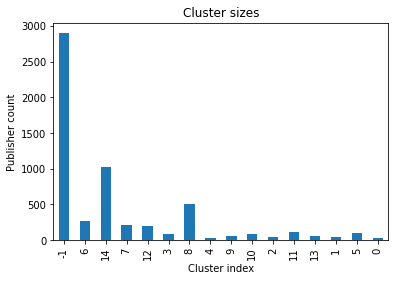

In [24]:
dbscan_best_labels = dbscan_labels[parameters.index((final_eps, final_ms))]
dbscan_cluster_size_plot(X_intermediate, dbscan_best_labels, media_count)

With DBScan, the distribution of publisher across clusters is a lot less uniform. However, a lot of clusters make sense. This way of creating clusters seems very promising.

In [25]:
data = np.concatenate((dbscan_best_labels.reshape((-1, 1)), X_2d, X_3d), axis=1)
columns_names = ['cluster_id', 'x1', 'y1', 'x2', 'y2', 'z2']
clustered_media = pd.DataFrame(index=media_count.index, columns=columns_names, data=data)
display(clustered_media)

,cluster_id,x1,y1,x2,y2,z2
journal,,,,,,
1011now.com,-1.0,0.514125,-0.088614,0.514054,-0.088537,-0.162709
1070thefan.com,-1.0,-0.333263,-0.320065,-0.333378,-0.319923,0.126778
107jamz.com,6.0,-0.141945,-0.487175,-0.141768,-0.487365,-0.429182
10news.com,14.0,0.578854,-0.043905,0.578850,-0.043942,-0.089970
1130thetiger.com,-1.0,0.098002,-0.328628,0.098064,-0.328662,-0.101700
...,...,...,...,...,...,...
zalebs.com,-1.0,-0.361362,-0.331424,-0.361444,-0.331258,0.294870
zawya.com,14.0,0.507993,0.299229,0.507999,0.299231,0.086460
zdnet.com,-1.0,0.010700,0.384382,0.010641,0.384200,0.328471


In [26]:
clustered_media.to_csv("../data/clusters.csv.bz2")

## Conclusion

Applying DBScan on our clean version of quotebank yields good, multi facetted clusters that would be ripe for further analysis. KMeans in comparison seems to generalize much more. With a little bit more time, we would also like to try other clustering methods, like agglomerative clustering for example.